In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
URL = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

In [3]:
features = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP"
]

- Data Preparation

In [4]:
df = pd.read_csv(URL)
df = df[features]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df["above_average"] = [1 if x > df["msrp"].mean() else 0 for x in df["msrp"]]
df.drop("msrp", axis=1, inplace=True)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values

In [8]:
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [9]:
categorical = [
    "make", 
    "model", 
    "transmission_type", 
    "vehicle_style"
    ]

- **Question 1** : ROC AUC feature importance

In [10]:
numerical = [
    "year",
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg"
]

In [11]:
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print(f'{col}, {round(auc, 3)}')
     

year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
city_mpg, 0.673


*Answer* : engine_hp

- **Question 2:** Training the model

In [12]:
dv = DictVectorizer(sparse=False)

In [13]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
model = LogisticRegression(
    solver='liblinear', 
    C=1.0, 
    max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [15]:
y_pred = model.predict(X_val)

In [16]:
round(roc_auc_score(y_val, y_pred), 3)

0.915

*Answer:* 0.979

- **Question 3**: Precision and Recall

In [17]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

In [18]:
columns = ["thresholds", "tp", "fp", "fn", "tn", "precision", "recall"]
df_scores = pd.DataFrame(scores, columns=columns)

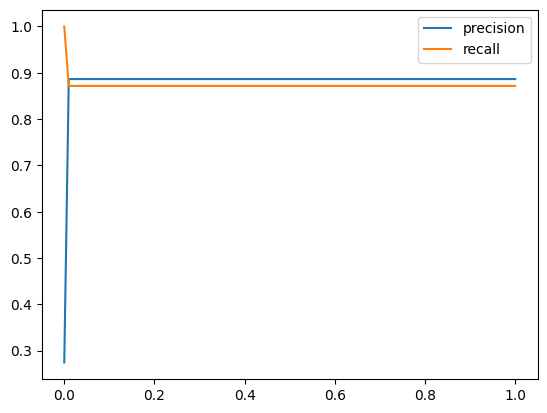

In [19]:
plt.plot(df_scores["thresholds"], df_scores["precision"], label="precision")
plt.plot(df_scores["thresholds"], df_scores["recall"], label="recall")
plt.legend()

*Answer*: 0.88

- **Question 4**: F1 Score

In [20]:
df_scores['f1'] = 2 * df_scores["precision"] * df_scores["recall"] / (df_scores["precision"] + df_scores["recall"])

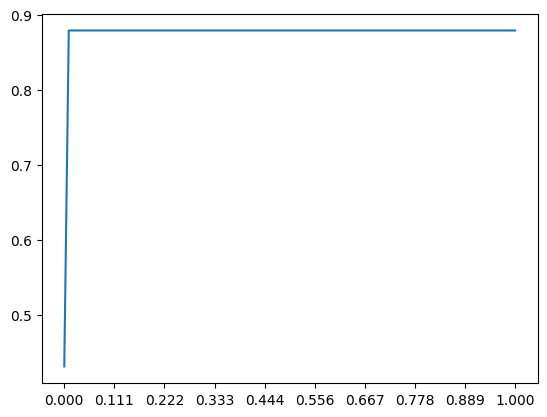

In [21]:
plt.plot(df_scores["thresholds"], df_scores["f1"])
plt.xticks(np.linspace(0, 1, 10))
plt.show()

*Answer:* 0.12

- **Question 5:** 5-Fold CV

In [22]:
columns = categorical + numerical

In [23]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [24]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train["above_average"]
    y_val = df_val["above_average"]

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'{round(np.mean(scores), 3)} +- {round(np.std(scores), 3)}')

0.979 +- 0.003


*Answer:* 0.003

- **Question 6 :** Hyperparameter Tuning

In [25]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train["above_average"]
        y_val = df_val["above_average"]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C = {C}, {round(np.mean(scores), 3)} +- {round(np.std(scores), 3)}')
     

C = 0.01, 0.952 +- 0.002
C = 0.1, 0.972 +- 0.002
C = 1, 0.979 +- 0.003
C = 10, 0.983 +- 0.003


*Answer :*  10